In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data import train, validation
from data import X, y
from utils import StandardizedGridSearchCV

c = 12
p = 20
s = 8

# Univariate optimization

In [27]:
from scipy import stats

def univariate_optimization(dist, c=c, p=p, s=s):
    return dist.ppf((p-c)/(p-s))

# Distributions to fit
distributions = {
    'normal': stats.norm,
    'expon': stats.expon,
    'lognormal': stats.lognorm,
}

# Fit all distributions to train sales
distributions = {
    name: dist(*dist.fit(train[y]))
    for name, dist in distributions.items()
}

# Add an additional empirical distribution
distributions['ecdf'] = stats.rv_histogram(np.histogram(train[y], bins=train.shape[0]))

# Collate optimal solutions for each distribution
records = []
for name, dist in distributions.items():
    records.append({
        'distribution': name,
        'solution': univariate_optimization(dist=dist),
    })
univariate = pd.DataFrame.from_records(records)
univariate

,distribution,solution
0,normal,100.234685
1,expon,62.166011
2,lognormal,41.943465
3,ecdf,42.870338


## Optimal univariate sales decision

In [28]:
def profit(demand, inventory, c=c, p=p, s=s):
    return (p-s)*np.minimum(demand, inventory) - (c-s)*inventory
    
    
# Compute mean daily cost of each solution upon realization of sales (train and validation set)
# univariate['train_profit'] = univariate['solution'].apply(lambda x: profit(train[y], x).mean())
univariate['profit_mean'] = univariate['solution'].apply(lambda x: profit(validation[y], x).mean())
univariate['profit_std'] = univariate['solution'].apply(lambda x: profit(validation[y], x).std())
univariate = univariate.sort_values('profit_mean', ascending=False).reset_index(drop=True)
univariate

,distribution,solution,profit_mean,profit_std
0,lognormal,41.943465,114.449422,183.613635
1,ecdf,42.870338,114.333263,187.968893
2,expon,62.166011,99.751055,271.383431
3,normal,100.234685,28.390925,407.034554


In [29]:
y_star = univariate['solution'].values[0]
c_star = univariate['profit_mean'].values[0]

print(f'{c_star = }') # Optimal profit
print(f'{y_star = }') # Optimal decision

c_star = 114.44942163825823
y_star = 41.94346506272842


# Sales prediction as inventory

In [30]:
# Load final model
ensemble = StandardizedGridSearchCV.load('ensemble.p')
ensemble = ensemble.best_estimator_

# Load cached final predictions from submodels
pred_train = pd.read_csv('predictions/train.csv', index_col=0)
pred_val = pd.read_csv('predictions/validation.csv', index_col=0)

# Fit final model to train data
ensemble.fit(pred_train, train[y])

LinearRegression()

In [31]:
# Individual model performance
best_model_profits = profit(
    validation[y], 
    np.maximum(0, pred_val.iloc[:, 0]).values,
)

print(f'{best_model_profits.mean() = }')
print(f'{best_model_profits.std()  = }')

best_model_profits.mean() = 334.02008076274115
best_model_profits.std()  = 654.2507962763729


In [32]:
# Ensemble model performance
meta_model_profits = profit(
    validation[y], 
    np.maximum(0, ensemble.predict(pred_val))
)
print(f'{meta_model_profits.mean() = }')
print(f'{meta_model_profits.std()  = }')

meta_model_profits.mean() = 339.0054238791992
meta_model_profits.std()  = 649.5073831690084


# Combined model

We combine the solutions by taking a weighted average of solutions from univariate optimization and our sales forecasts. To obtain the weights, we use logistic regression to predict the probability that the sales forecast will perform better than the univariate optimization method. This "model confidence model" is fit on our train split and evaluated on our test split.

In [33]:
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Get best previously obtained solutions on train set
y_star_train = y_star
y_meta_train = np.maximum(0, ensemble.predict(pred_train)) 

# Compute profits
c_star_train = profit(train[y], y_star_train)
c_meta_train = profit(train[y], y_meta_train)

# Fit a logistic regression to predict probability of model forecasts outperforming univariate optimizations
error_model = LogisticRegressionCV(max_iter=10000, scoring='balanced_accuracy')
error_model.fit(train[X], c_meta_train > c_star_train)

LogisticRegressionCV(max_iter=10000, scoring='balanced_accuracy')

## Grid Search for mixing parameter to maximize profits

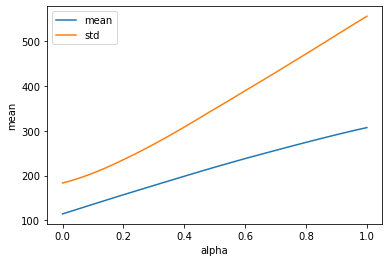

,alpha,mean,std
100,1.00,307.508694,556.451087
99,0.99,305.978810,552.299901
98,0.98,304.448414,548.160384
97,0.97,302.906781,544.032912
96,0.96,301.350159,539.908072


In [34]:
y_meta = np.maximum(0, ensemble.predict(pred_val))
weights = error_model.predict_proba(validation[X])[:, 1]
odds = np.exp(weights)
probs = odds / (1+odds)

records = []
for alpha in np.linspace(0, 1, 101):
    w = alpha * probs
    mixed_preds = np.maximum(0, w*y_meta + (1-w)*y_star)
    mixed_costs = profit(validation[y], mixed_preds)
    records.append({
        'alpha': alpha,
        'mean': mixed_costs.mean(),
        'std': mixed_costs.std(),
    })

costs = pd.DataFrame.from_records(records)
sns.lineplot(x='alpha', y='mean', data=costs)
sns.lineplot(x='alpha', y='std', data=costs)
plt.legend(['mean', 'std'])
plt.show()

costs.sort_values('mean', ascending=False).head()

Unfortunately, this method does not yield better results than using forecasts directly. This is likely due the difficulty of fitting an error model that can accurately predict when a model will perform badly. We can see the poor performance of the error model from the ROC plot below. Hence, we will be using sales forecasts directly for inventory prediction.

array([[   1,  185],
       [   0, 1806]])

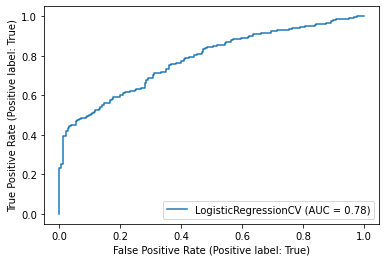

In [35]:
from sklearn.metrics import confusion_matrix, plot_roc_curve

plot_roc_curve(error_model, train[X], c_meta_train > c_star_train)
confusion_matrix(y_true=c_meta_train > c_star_train, y_pred=error_model.predict(train[X]))